In [1]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import dataset

In [2]:
from io import StringIO
from io import BytesIO
from zipfile import ZipFile
import urllib.request

In [4]:
df=pd.read_csv('final data.csv')
df.shape

(488849, 134)

In [5]:
y=np.where(df['Injury Severity']=='KILLED',1,0)
y

array([0, 1, 1, ..., 0, 0, 0])

In [6]:
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 488849
    Positive: 1494 (0.31% of total)



In [7]:
X=df.iloc[:,1:].copy()
X

,Crash_Month,Crash_Day,Crash_Minute,Crash_AM/PM,Crash_Hour,Unit_Nbr,Prsn_Age,Toll_Road_Fl,Crash_Speed_Limit,Road_Constr_Zone_Fl,...,Traffic_Cntl_ID_STOP SIGN,Traffic_Cntl_ID_WARNING SIGN,Traffic_Cntl_ID_YIELD SIGN,Unit_Desc_ID_MOTORIZED CONVEYANCE,Unit_Desc_ID_NON-CONTACT,Unit_Desc_ID_OTHER (EXPLAIN IN NARRATIVE),Unit_Desc_ID_PEDALCYCLIST,Unit_Desc_ID_PEDESTRIAN,Unit_Desc_ID_TOWED/PUSHED/TRAILER,Unit_Desc_ID_TRAIN
0,7,20,37,0,3,3,26,0,55,0,...,0,0,0,0,0,0,0,0,0,0
1,7,27,45,0,11,3,61,0,75,0,...,0,0,0,0,0,0,0,0,0,0
2,8,10,5,1,5,2,55,0,55,0,...,0,0,0,0,0,0,0,0,0,0
3,7,21,17,1,6,2,84,0,65,0,...,0,0,0,0,0,0,0,0,0,0
4,8,27,26,0,7,2,78,0,75,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488844,11,29,13,0,11,1,68,0,70,0,...,0,0,0,0,0,0,0,0,0,0
488845,11,25,6,0,11,1,44,0,55,0,...,1,0,0,0,0,0,0,0,0,0
488846,11,25,6,0,11,2,57,0,55,0,...,1,0,0,0,0,0,0,0,0,0
488847,9,3,15,1,4,1,16,0,40,0,...,1,0,0,0,0,0,0,0,0,0


# Split the dataset

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train, random_state=48)

X_train=np.array(X_train)
X_test=np.array(X_test)
X_val=np.array(X_val)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training features shape: (312863, 133)
Validation features shape: (78216, 133)
Test features shape: (97770, 133)


In [10]:
y_train=np.array(y_train).reshape(len(y_train),1)
y_test=np.array(y_test).reshape(len(y_test),1)
y_val=np.array(y_val).reshape(len(y_val),1)

print('Training features shape:', y_train.shape)
print('Validation features shape:', y_val.shape)
print('Test features shape:', y_test.shape)

Training features shape: (312863, 1)
Validation features shape: (78216, 1)
Test features shape: (97770, 1)


In [11]:
# standardization
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# MLP simple

## Mini functions

### Create model

In [13]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.1.0


In [14]:
def create_model(nodes=20,actih='relu',actio='sigmoid',lr=1e-3,output_bias=None,logits=False):
    model = keras.Sequential()
    model.add(keras.layers.Dense(nodes, activation=actih,input_dim=X_train.shape[1]))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1, activation=actio,bias_initializer=output_bias))
    
    model.compile(optimizer=keras.optimizers.Adam(lr=lr),
                  loss=keras.losses.BinaryCrossentropy(from_logits=logits),
                  metrics=metrics)
    return model

### Show confusion matrix


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
def CI(arr):
    op=[arr[0,0],arr[1,1]]/arr.sum(axis=0)
    op=np.append(op,(arr[0,0]+arr[1,1])/arr.sum())
    op=pd.DataFrame(op,columns=['Precision'],index=['0','1','Global'])
    op['n_p']=np.append(arr.sum(axis=0),arr.sum())
    op['CI_p']=196*np.sqrt(op.Precision*(1-op.Precision)/op.n_p)
    op['Precision']=op.Precision*100

    op['Recall']=np.append([arr[0,0],arr[1,1]]/arr.sum(axis=1),(arr[0,0]+arr[1,1])/arr.sum())
    op['n_r']=np.append(arr.sum(axis=1),arr.sum())
    op['CI_r']=196*np.sqrt(op.Recall*(1-op.Recall)/op.n_r)
    op['Recall']=op.Recall*100
    return op

In [17]:
def show_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    print(cm)
    pcm=classification_report(labels, predictions > p, target_names=['Class 0','Class 1']) 
    print(pcm)
    return CI(cm)

### Plot ROC


In [18]:
from sklearn.metrics import roc_curve, auc

In [19]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name + ' (area = %0.4f)' % auc(fp, tp), linewidth=1.5, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100.5])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [20]:
data_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
data_train

<TensorSliceDataset shapes: ((133,), (1,)), types: (tf.float64, tf.int32)>

In [21]:
data_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
data_val

<TensorSliceDataset shapes: ((133,), (1,)), types: (tf.float64, tf.int32)>

In [22]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.78753572])

In [31]:
metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc')]

In [25]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [26]:
tf.random.set_seed(8)

In [27]:
batch_size=2048
data_train = data_train.shuffle(len(X_train)).batch(batch_size)
data_val = data_val.shuffle(len(X_val)).batch(batch_size)

In [28]:
import time

## Base model


In [70]:
start_time=time.time()
ar_model=create_model()
Monitor = ar_model.fit(data_train, epochs=100,callbacks=[es],validation_data = data_val, verbose = 1)
end_time=time.time()
end_time-start_time

Epoch 1/100
153/153 [==============================] - 4s 23ms/step - loss: 0.1941 - accuracy: 0.9729 - precision: 0.0090 - recall: 0.0720 - auc: 0.5318 - val_loss: 0.0474 - val_accuracy: 0.9969 - val_precision: 0.2000 - val_recall: 0.0084 - val_auc: 0.5524
Epoch 2/100
153/153 [==============================] - 3s 21ms/step - loss: 0.0615 - accuracy: 0.9954 - precision: 0.0462 - recall: 0.0262 - auc: 0.6279 - val_loss: 0.0233 - val_accuracy: 0.9969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8094
Epoch 3/100
153/153 [==============================] - 3s 21ms/step - loss: 0.0398 - accuracy: 0.9965 - precision: 0.1250 - recall: 0.0241 - auc: 0.7288 - val_loss: 0.0177 - val_accuracy: 0.9969 - val_precision: 0.4000 - val_recall: 0.0084 - val_auc: 0.8651
Epoch 4/100
153/153 [==============================] - 3s 21ms/step - loss: 0.0318 - accuracy: 0.9967 - precision: 0.1912 - recall: 0.0272 - auc: 0.7542 - val_loss: 0.0160 - val_accuracy: 0.9969 - val_precision: 0.2500

52.8734016418457

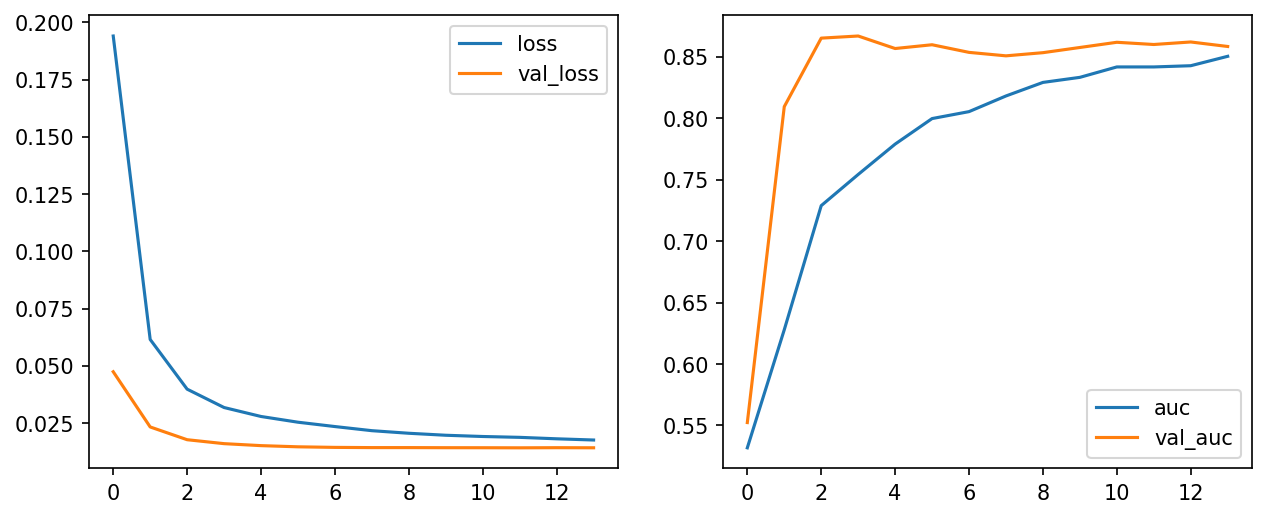

In [71]:
hist = pd.DataFrame(Monitor.history)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['auc','val_auc']].plot(ax=axes[1])
plt.show()

### Results


In [0]:
y_pred_train_b = ar_model.predict(X_train)
y_pred_test_b = ar_model.predict(X_test)

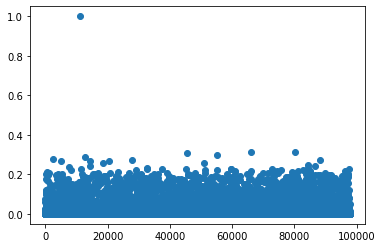

In [73]:
plt.scatter(np.arange(len(y_test)),y_pred_test_b)

In [74]:
show_cm(y_test,y_pred_test_b)

[[97470     1]
 [  299     0]]
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     97471
     Class 1       0.00      0.00      0.00       299

    accuracy                           1.00     97770
   macro avg       0.50      0.50      0.50     97770
weighted avg       0.99      1.00      1.00     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.694177,97769,0.034612,99.998974,97471,0.002011
1,0.000000,1,0.000000,0.000000,299,0.000000
Global,99.693157,97770,0.034669,99.693157,97770,0.034669


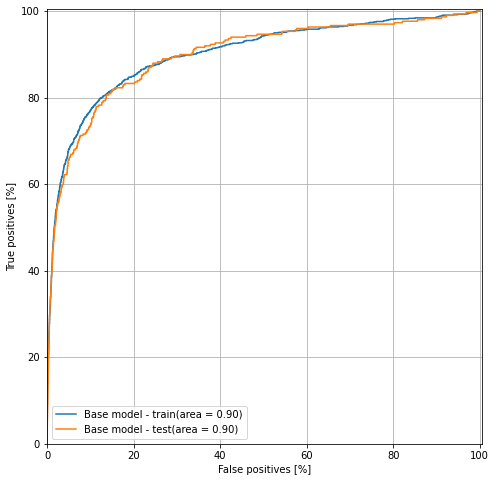

In [75]:
plt.figure(figsize=(8,8))
plot_roc('Base model - train',y_train,y_pred_train_b)
plot_roc('Base model - test',y_test,y_pred_test_b)
plt.legend()
plt.show()

# Class weight

### Class weight estimation

In [30]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 163.60


### Run model with class weight

In [31]:
tf.random.set_seed(8)
start_time=time.time()
wei_model=create_model()
Monitor = wei_model.fit(data_train, epochs=100,callbacks=[es],validation_data = data_val,class_weight=class_weight, verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

Train for 153 steps, validate for 39 steps
Epoch 1/100
153/153 [==============================] - 7s 49ms/step - loss: 0.6786 - accuracy: 0.6962 - auc: 0.7438 - val_loss: 0.4224 - val_accuracy: 0.8277 - val_auc: 0.9146
Epoch 2/100
153/153 [==============================] - 6s 38ms/step - loss: 0.4772 - accuracy: 0.8120 - auc: 0.8671 - val_loss: 0.3675 - val_accuracy: 0.8725 - val_auc: 0.9299
Epoch 3/100
153/153 [==============================] - 8s 56ms/step - loss: 0.4170 - accuracy: 0.8562 - auc: 0.9010 - val_loss: 0.3467 - val_accuracy: 0.8860 - val_auc: 0.9310
Epoch 4/100
153/153 [==============================] - 9s 61ms/step - loss: 0.3922 - accuracy: 0.8721 - auc: 0.9122 - val_loss: 0.3400 - val_accuracy: 0.8896 - val_auc: 0.9333
Epoch 5/100
153/153 [==============================] - 7s 46ms/step - loss: 0.3589 - accuracy: 0.8817 - auc: 0.9274 - val_loss: 0.3327 - val_accuracy: 0.8913 - val_auc: 0.9341
Epoch 6/100
153/153 [==============================] - 7s 44ms/step - loss: 0

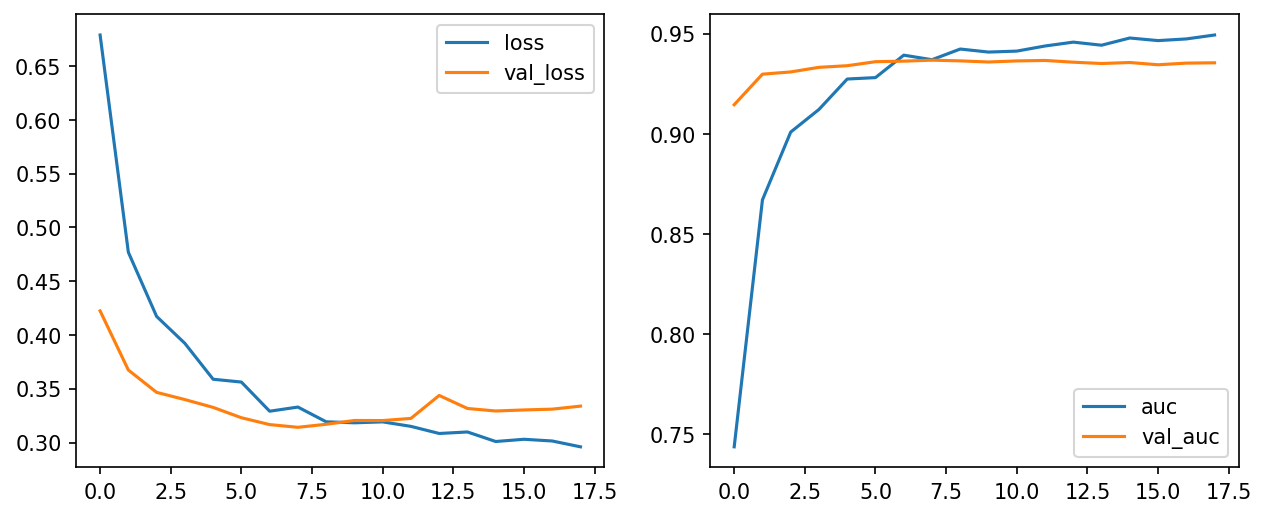

In [32]:
hist = pd.DataFrame(Monitor.history)
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,4),dpi=150)
hist[['loss','val_loss']].plot(ax=axes[0])
hist[['auc','val_auc']].plot(ax=axes[1])
plt.show()

In [33]:
y_pred_train_b = wei_model.predict(X_train)
y_pred_test_b = wei_model.predict(X_test)

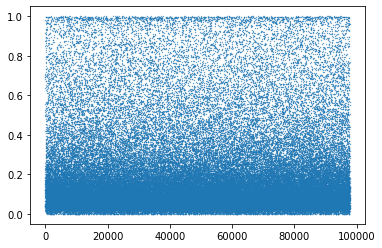

In [34]:
plt.scatter(np.arange(len(y_test)),y_pred_test_b,s=0.1)
plt.show()

In [35]:
show_cm(y_test,y_pred_test_b)

[[86734 10737]
 [   27   272]]
              precision    recall  f1-score   support

     Class 0       1.00      0.89      0.94     97471
     Class 1       0.02      0.91      0.05       299

    accuracy                           0.89     97770
   macro avg       0.51      0.90      0.49     97770
weighted avg       1.00      0.89      0.94     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.968880,86761,0.011737,88.984416,97471,0.196553
1,2.470706,11009,0.289975,90.969900,299,3.248745
Global,88.990488,97770,0.196205,88.990488,97770,0.196205


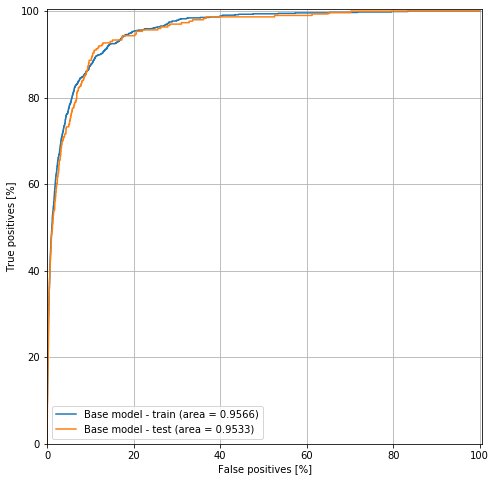

In [36]:
plt.figure(figsize=(8,8))
plot_roc('Base model - train',y_train,y_pred_train_b)
plot_roc('Base model - test',y_test,y_pred_test_b)
plt.legend()
plt.show()

## Optimized model


In [37]:
start_time=time.time()
tf.random.set_seed(8)
wei_model=create_model(lr=0.01)
Monitor = wei_model.fit(X_train,y_train, epochs=100,batch_size=4096, callbacks=[es],validation_data = (X_val,y_val),class_weight=class_weight, verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 312863 samples, validate on 78216 samples
Epoch 1/100
312863/312863 [==============================] - 4s 13us/sample - loss: 0.5208 - accuracy: 0.8152 - auc: 0.8573 - val_loss: 0.3366 - val_accuracy: 0.8939 - val_auc: 0.9374
Epoch 2/100
312863/312863 [==============================] - 3s 9us/sample - loss: 0.3551 - accuracy: 0.8939 - auc: 0.9291 - val_loss: 0.3138 - val_accuracy: 0.9001 - val_auc: 0.9396
Epoch 3/100
312863/312863 [==============================] - 3s 8us/sample - loss: 0.3346 - accuracy: 0.8976 - auc: 0.9368 - val_loss: 0.3167 - val_accuracy: 0.8865 - val_auc: 0.9397
Epoch 4/100
312863/312863 [==============================] - 3s 9us/sample - loss: 0.3304 - accuracy: 0.8927 - auc: 0.9375 - val_loss: 0.3140 - val_accuracy: 0.8779 - val_auc: 0.9435
Epoch 5/100
312863/312863 [==============================] - 3s 8us/sample - loss: 0.3272 - accuracy: 0.8934 - auc: 0.9382 - val_loss: 0.3263 - val_accuracy: 0.8975 -

In [38]:
wei_model.evaluate(X_test,y_test)

97770/97770 [==============================] - 4s 45us/sample - loss: 0.3687 - accuracy: 0.8757 - auc: 0.9563


[0.3686799277261416, 0.8756674, 0.9563151]

In [39]:
y_pred_train_w = wei_model.predict(X_train)
y_pred_test_w = wei_model.predict(X_test)

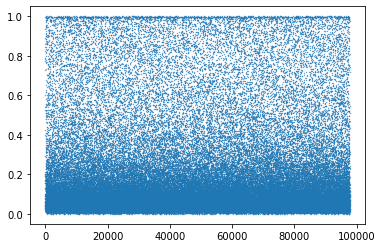

In [40]:
plt.scatter(np.arange(len(y_test)),y_pred_test_w,s=0.1)
plt.show()

In [41]:
show_cm(y_test,y_pred_test_w)

[[85339 12132]
 [   24   275]]
              precision    recall  f1-score   support

     Class 0       1.00      0.88      0.93     97471
     Class 1       0.02      0.92      0.04       299

    accuracy                           0.88     97770
   macro avg       0.51      0.90      0.49     97770
weighted avg       1.00      0.88      0.93     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.971885,85363,0.011247,87.553221,97471,0.207244
1,2.216491,12407,0.259053,91.973244,299,3.079791
Global,87.566738,97770,0.206831,87.566738,97770,0.206831


In [44]:
weighted_results = wei_model.evaluate(X_test,y_test,batch_size=4096)
for name, value in zip(wei_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

97770/97770 [==============================] - 1s 6us/sample - loss: 0.3687 - accuracy: 0.8757 - auc: 0.9563
loss :  0.3686799493306154
accuracy :  0.8756674
auc :  0.9563151



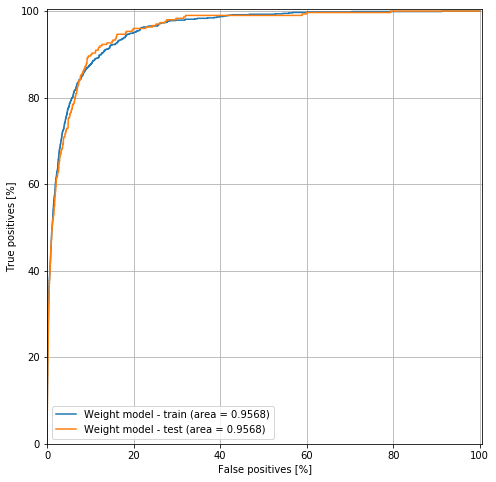

In [45]:
plt.figure(figsize=(8,8))
plot_roc('Weight model - train',y_train,y_pred_train_w)
plot_roc('Weight model - test',y_test,y_pred_test_w)
plt.legend()
plt.show()

# Resampling

## Preparing new dataset

In [146]:
bool_y_train = y_train != 0
bool_y_train=np.reshape(bool_y_train, (len(bool_y_train),))
pos_X = X_train[bool_y_train]
neg_X = X_train[~bool_y_train]

pos_y = y_train[bool_y_train]
neg_y = y_train[~bool_y_train]

In [147]:
# oversampling
ids = np.arange(len(pos_X))
#print(len(pos_X))
choices = np.random.choice(ids, len(neg_X))
#print(len(neg_X))
res_pos_X = pos_X[choices]
res_pos_y = pos_y[choices]

res_pos_X.shape

(311907, 133)

In [148]:
# Concatenate
resampled_X = np.concatenate([res_pos_X, neg_X], axis=0)
resampled_y = np.concatenate([res_pos_y, neg_y], axis=0)

order = np.arange(len(resampled_y))
np.random.shuffle(order)
resampled_X= resampled_X[order]
resampled_y = resampled_y[order]

resampled_X.shape

(623814, 133)

In [149]:
new_pos=resampled_y.sum()
new_neg=len(resampled_y)-new_pos
new_total = new_neg + new_pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(new_total, new_pos, 100 * new_pos / new_total))

Examples:
    Total: 623814
    Positive: 311907 (50.00% of total)



In [150]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / new_neg)*(new_total)/2.0 
weight_for_1 = (1 / new_pos)*(new_total)/2.0

new_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


In [151]:
start_time=time.time()
tf.random.set_seed(8)
res_model=create_model(lr=0.01)
Monitor = res_model.fit(resampled_X,resampled_y, 
                        epochs=100,batch_size=4096, 
                        callbacks=[es],
                        validation_data = (X_val,y_val),
                        class_weight=new_class_weight,
                        verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 623814 samples, validate on 78216 samples
Epoch 1/100
623814/623814 [==============================] - 13s 21us/sample - loss: 0.3136 - accuracy: 0.8737 - auc: 0.9443 - val_loss: 0.2356 - val_accuracy: 0.9056 - val_auc: 0.9327
Epoch 2/100
623814/623814 [==============================] - 5s 9us/sample - loss: 0.2417 - accuracy: 0.9034 - auc: 0.9643 - val_loss: 0.2203 - val_accuracy: 0.9076 - val_auc: 0.9260
Epoch 3/100
623814/623814 [==============================] - 5s 9us/sample - loss: 0.2224 - accuracy: 0.9125 - auc: 0.9685 - val_loss: 0.1775 - val_accuracy: 0.9205 - val_auc: 0.9194
Epoch 4/100
623814/623814 [==============================] - 6s 9us/sample - loss: 0.2118 - accuracy: 0.9185 - auc: 0.9704 - val_loss: 0.1802 - val_accuracy: 0.9186 - val_auc: 0.9171
Epoch 5/100
623814/623814 [==============================] - 5s 8us/sample - loss: 0.2067 - accuracy: 0.9213 - auc: 0.9713 - val_loss: 0.1686 - val_accuracy: 0.9216 

In [152]:
res_results = res_model.evaluate(X_test,y_test,batch_size=4096)
for name, value in zip(res_model.metrics_names, res_results):
  print(name, ': ', value)
print()

97770/97770 [==============================] - 1s 10us/sample - loss: 0.2391 - accuracy: 0.9037 - auc: 0.9554
loss :  0.23914049208572674
accuracy :  0.9037128
auc :  0.95540607



In [153]:
y_pred_train_r = res_model.predict(X_train)
y_pred_test_r = res_model.predict(X_test)

In [154]:
show_cm(y_test,y_pred_test_r)

[[88097  9374]
 [   40   259]]
              precision    recall  f1-score   support

     Class 0       1.00      0.90      0.95     97471
     Class 1       0.03      0.87      0.05       299

    accuracy                           0.90     97770
   macro avg       0.51      0.89      0.50     97770
weighted avg       1.00      0.90      0.95     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.954616,88137,0.014061,90.382781,97471,0.185091
1,2.688674,9633,0.323018,86.622074,299,3.858595
Global,90.371280,97770,0.184907,90.371280,97770,0.184907


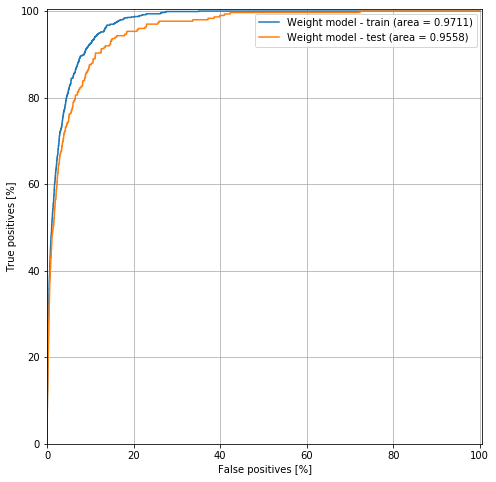

In [155]:
plt.figure(figsize=(8,8))
plot_roc('Weight model - train',y_train,y_pred_train_r)
plot_roc('Weight model - test',y_test,y_pred_test_r)
plt.legend()
plt.show()

# SMOTE

In [29]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_smote))

Resampled dataset shape Counter({0: 311907, 1: 311907})


In [30]:
start_time=time.time()
tf.random.set_seed(8)
smote_model=create_model(lr=0.01)
Monitor = smote_model.fit(X_smote,y_smote, 
                        epochs=100,batch_size=4096, 
                        callbacks=[es],
                        validation_data = (X_val,y_val),
                        verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

Train on 623814 samples, validate on 78216 samples
Epoch 1/100
623814/623814 [==============================] - 6s 10us/sample - loss: 0.3006 - accuracy: 0.8796 - auc: 0.9486 - val_loss: 0.2134 - val_accuracy: 0.9132 - val_auc: 0.9309
Epoch 2/100
623814/623814 [==============================] - 5s 9us/sample - loss: 0.2313 - accuracy: 0.9088 - auc: 0.9665 - val_loss: 0.1870 - val_accuracy: 0.9198 - val_auc: 0.9222
Epoch 3/100
623814/623814 [==============================] - 5s 8us/sample - loss: 0.2151 - accuracy: 0.9167 - auc: 0.9696 - val_loss: 0.1677 - val_accuracy: 0.9264 - val_auc: 0.9168
Epoch 4/100
623814/623814 [==============================] - 5s 9us/sample - loss: 0.2077 - accuracy: 0.9203 - auc: 0.9710 - val_loss: 0.1734 - val_accuracy: 0.9262 - val_auc: 0.9136
Epoch 5/100
623814/623814 [==============================] - 5s 8us/sample - loss: 0.2027 - accuracy: 0.9228 - auc: 0.9720 - val_loss: 0.1554 - val_accuracy: 0.9324 - val_auc: 0.9073
Epoch 6/100
623814/623814 [======

In [32]:
smote_results = smote_model.evaluate(X_test,y_test,batch_size=4096)
for name, value in zip(smote_model.metrics_names, smote_results):
  print(name, ': ', value)
print()

97770/97770 [==============================] - 1s 6us/sample - loss: 0.2161 - accuracy: 0.9114 - auc: 0.9535
loss :  0.21609678424135045
accuracy :  0.9114452
auc :  0.9535118



In [34]:
y_pred_train_sm = smote_model.predict(X_train)
y_pred_test_sm = smote_model.predict(X_test)

In [35]:
show_cm(y_test,y_pred_test_sm)

[[88856  8615]
 [   43   256]]
              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95     97471
     Class 1       0.03      0.86      0.06       299

    accuracy                           0.91     97770
   macro avg       0.51      0.88      0.50     97770
weighted avg       1.00      0.91      0.95     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.951631,88899,0.014454,91.161474,97471,0.178203
1,2.885808,8871,0.348373,85.618729,299,3.977439
Global,91.144523,97770,0.178084,91.144523,97770,0.178084


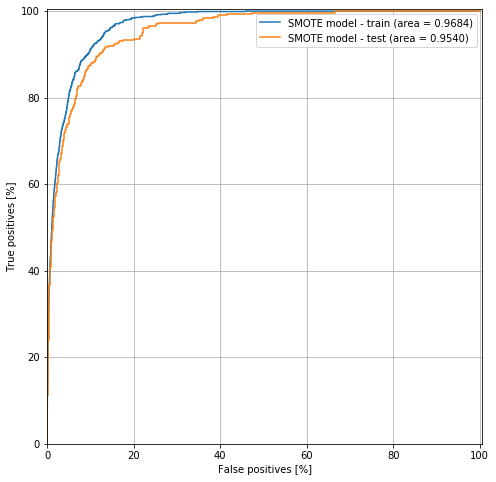

In [36]:
plt.figure(figsize=(8,8))
plot_roc('SMOTE model - train',y_train,y_pred_train_sm)
plot_roc('SMOTE model - test',y_test,y_pred_test_sm)
plt.legend()
plt.show()

# ADASYN

In [37]:
from imblearn.over_sampling import ADASYN # doctest: +NORMALIZE_WHITESPACE

ada = ADASYN(random_state=42)
X_ada, y_ada = ada.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_ada))

Resampled dataset shape Counter({0: 311907, 1: 311780})


In [38]:
start_time=time.time()
tf.random.set_seed(8)
ada_model=create_model(lr=0.01)
Monitor = ada_model.fit(X_ada,y_ada, 
                        epochs=100,batch_size=4096, 
                        callbacks=[es],
                        validation_data = (X_val,y_val),
                        verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

Train on 623687 samples, validate on 78216 samples
Epoch 1/100
623687/623687 [==============================] - 7s 12us/sample - loss: 0.3080 - accuracy: 0.8760 - precision: 0.8789 - recall: 0.8720 - auc: 0.9457 - val_loss: 0.2257 - val_accuracy: 0.9072 - val_precision: 0.0272 - val_recall: 0.8452 - val_auc: 0.9325
Epoch 2/100
623687/623687 [==============================] - 5s 9us/sample - loss: 0.2365 - accuracy: 0.9076 - precision: 0.8944 - recall: 0.9242 - auc: 0.9642 - val_loss: 0.2028 - val_accuracy: 0.9129 - val_precision: 0.0275 - val_recall: 0.7992 - val_auc: 0.9195
Epoch 3/100
623687/623687 [==============================] - 5s 9us/sample - loss: 0.2211 - accuracy: 0.9153 - precision: 0.8938 - recall: 0.9426 - auc: 0.9673 - val_loss: 0.1755 - val_accuracy: 0.9222 - val_precision: 0.0297 - val_recall: 0.7741 - val_auc: 0.9101
Epoch 4/100
623687/623687 [==============================] - 5s 8us/sample - loss: 0.2142 - accuracy: 0.9185 - precision: 0.8929 - recall: 0.9511 - auc: 

In [39]:
ada_results = ada_model.evaluate(X_test,y_test,batch_size=4096)
for name, value in zip(ada_model.metrics_names, ada_results):
  print(name, ': ', value)
print()

97770/97770 [==============================] - 1s 6us/sample - loss: 0.2286 - accuracy: 0.9054 - precision: 0.0273 - recall: 0.8662 - auc: 0.9513
loss :  0.2285738522175254
accuracy :  0.9053595
precision :  0.02734375
recall :  0.8662207
auc :  0.95125526



In [40]:
y_pred_train_ada = ada_model.predict(X_train)
y_pred_test_ada = ada_model.predict(X_test)

In [41]:
show_cm(y_test,y_pred_test_ada)

[[88258  9213]
 [   40   259]]
              precision    recall  f1-score   support

     Class 0       1.00      0.91      0.95     97471
     Class 1       0.03      0.87      0.05       299

    accuracy                           0.91     97770
   macro avg       0.51      0.89      0.50     97770
weighted avg       1.00      0.91      0.95     97770



,Precision,n_p,CI_p,Recall,n_r,CI_r
0,99.954699,88298,0.014036,90.547958,97471,0.183663
1,2.734375,9472,0.328431,86.622074,299,3.858595
Global,90.535952,97770,0.183486,90.535952,97770,0.183486


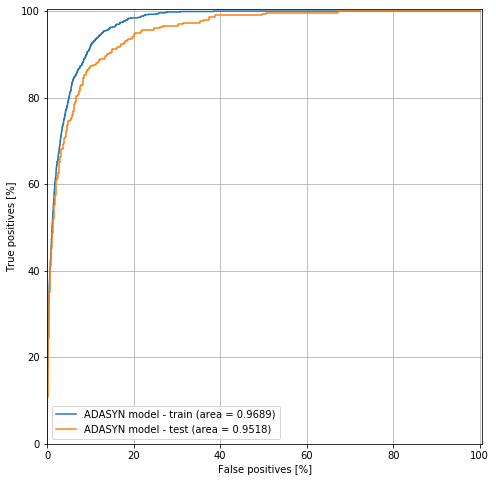

In [42]:
plt.figure(figsize=(8,8))
plot_roc('ADASYN model - train',y_train,y_pred_train_ada)
plot_roc('ADASYN model - test',y_test,y_pred_test_ada)
plt.legend()
plt.show()

# SMOTE and TOMEK

In [ ]:
from imblearn.combine import SMOTETomek # doctest: +NORMALIZE_WHITESPACE

smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_smt))

In [ ]:
start_time=time.time()
tf.random.set_seed(8)
smt_model=create_model(lr=0.01)
Monitor = smt_model.fit(X_smt,y_smt, 
                        epochs=100,batch_size=4096, 
                        callbacks=[es],
                        validation_data = (X_val,y_val),
                        verbose = 1)
end_time=time.time()
print('Computation time: ', (end_time-start_time)/60, ' min')

In [ ]:
smt_results = smt_model.evaluate(X_test,y_test,batch_size=4096)
for name, value in zip(smt_model.metrics_names, smt_results):
  print(name, ': ', value)
print()

In [ ]:
y_pred_train_smt = smt_model.predict(X_train)
y_pred_test_smt = smt_model.predict(X_test)

In [ ]:
show_cm(y_test,y_pred_test_smt)

In [ ]:
plt.figure(figsize=(8,8))
plot_roc('SMOTE&TOMEK model - train',y_train,y_pred_train_smt)
plot_roc('SMOTE%TOMEK model - test',y_test,y_pred_test_smt)
plt.legend()
plt.show()